# Changes:
1. Based on V36.1
2. Refactored data augmentor. Re-implement the rotate function to preserve positive mask area.
3. Use poly scheduler
4. Use SGD with momentum

## Install required packages if running on google colab

In [1]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

    100% |████████████████████████████████| 519.5MB 22kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x592e8000 @  0x7f864c6b42a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 7.1MB/s 
    100% |████████████████████████████████| 2.0MB 2.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 3.3MB 1.1MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
Cloning into 'salt_oil'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (

In [2]:
cd salt_oil

/content/salt_oil


## Import required libs

In [0]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import random
import PIL
import cv2 as cv
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [0]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.unet.resnet import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [0]:
## Setup data type based on whether GPU is enabled

In [6]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.cuda.FloatTensor'>


In [0]:
def setup_train(config_list):
    for conf in config_list:
        log.info(conf)
    for conf in config_list:
        exec(conf)

## Create Logger

In [0]:
global log
log = get_logger('salt_model_v37_refactor_aug_test1')

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [9]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


In [10]:
'''p = Pipeline_Salt()
p.random_brightness(1,0.8,1.2)
p.random_contrast(1,0.8,1.2)
p.rotate_random_align(probability=1)
img = np.c_[np.tile(X_train[840], 2), y_train[840]]
img_in = PIL.Image.fromarray(img)
tsfm = p.torch_transform()
img_out = tsfm(img_in)
plt.imshow(np.array(img_in)[:,:,0], cmap='gray')
plt.imshow(np.array(img_out)[:,:,0], cmap='gray')'''

"p = Pipeline_Salt()\np.random_brightness(1,0.8,1.2)\np.random_contrast(1,0.8,1.2)\np.rotate_random_align(probability=1)\nimg = np.c_[np.tile(X_train[840], 2), y_train[840]]\nimg_in = PIL.Image.fromarray(img)\ntsfm = p.torch_transform()\nimg_out = tsfm(img_in)\nplt.imshow(np.array(img_in)[:,:,0], cmap='gray')\nplt.imshow(np.array(img_out)[:,:,0], cmap='gray')"

### Train Val data split

In [0]:
df_train_mask = pd.DataFrame((np_train_all_mask/255).sum((1,2,3)), columns=['mask_pix'])
df_train_mask.mask_pix = df_train_mask.mask_pix.round(-2)

X_train_ids, X_val_ids = (
    train_test_split(df_train_mask.index.tolist(), 
                     test_size=0.20,
                     stratify = df_train_mask.mask_pix,
                     random_state=0)
)

X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)
#set mean image to 0 as mean is now being handled within the model.
X_train_mean_img = np.zeros_like(X_train_mean_img)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

assert X_train_mean_img == np.array([0.])
assert X_train.shape == (3200, 101, 101, 1)
assert y_train.shape == (3200, 101, 101, 1)
assert depth_train.shape == (3200, 1)

## Train the model using a small data set to see if it can overfit

In [0]:
aug_pipeline_config = '''
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.8, max_factor=1.0, mask_diff_pct=0.2)
'''

In [0]:
data_loader_config = '''
train_data_params = {'batch_size': 2, 'shuffle': True,}
val_data_params = {'batch_size': 2, 'shuffle': True,}
train_dataLoader = (
    DataLoader(SaltDataset(X_train[:16], y_train[:16], depth_train[:16],
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:8], y_val[:8], depth_val[:8], 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

'''

In [0]:
model_config = '''
saltnet = UResNet(pretrained=True)

loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

resnet_params = (
    list(saltnet.conv1.parameters()) + 
    list(saltnet.encoder2.parameters()) + 
    list(saltnet.encoder3.parameters()) + 
    list(saltnet.encoder4.parameters()) + 
    list(saltnet.encoder5.parameters())
)

unet_params = (
    list(saltnet.center.parameters()) + 
    list(saltnet.decoder5.parameters()) + 
    list(saltnet.decoder4.parameters()) + 
    list(saltnet.decoder3.parameters()) + 
    list(saltnet.decoder2.parameters()) + 
    list(saltnet.decoder1.parameters())  + 
    list(saltnet.se_f.parameters()) + 
    list(saltnet.outc.parameters())
)

#optimizer = optim.Adam([    
#    {'params': resnet_params, 'lr': 1e-4},
#    {'params': unet_params, 'lr': 1e-3},
#])
optimizer = optim.SGD([    
    {'params': resnet_params, 'lr': 1e-4},
    {'params': unet_params, 'lr': 1e-3},
], momentum=0.9, weight_decay=0.0001)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lr_lambda_enc, lr_lambda_dec])
scheduler = PolyLR(optimizer, [0.001,0.01], lr_decay_iter=1, max_iter=150, power=0.9)
model_save_name = None
'''

In [0]:
train_params_config = '''
train_params = {
    'model_save_name': None,
    'save_model_every': 10000,
    'save_log_every': 100,
    'num_epochs': 50,
    'print_every': 2,
    'log': log,
    'mask_cutoff': 0,
    'model_save_iou_threshold': 0.1
    }
'''

In [0]:
model_run_config = '''
model = train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.1), optimizer, scheduler, train_params, all_data)
'''

In [0]:
config_list = [aug_pipeline_config, data_loader_config, model_config, train_params_config, model_run_config]

04/10/2018 13:39:53 - salt_model_v37_refactor_aug_test1 - INFO - 
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.random_brightness(probability=0.5, min_factor=0.8, max_factor=1.2)
p.random_contrast(probability=0.5, min_factor=0.8, max_factor=1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.8, max_factor=1.0, mask_diff_pct=0.2)

04/10/2018 13:39:53 - salt_model_v37_refactor_aug_test1 - INFO - 
train_data_params = {'batch_size': 2, 'shuffle': True,}
val_data_params = {'batch_size': 2, 'shuffle': True,}
train_dataLoader = (
    DataLoader(SaltDataset(X_train[:16], y_train[:16], depth_train[:16],
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:8], y_val[:8], depth_val[:8], 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_da

ResNet using pretrained weights.


04/10/2018 13:39:54 - salt_model_v37_refactor_aug_test1 - INFO - Start Training...
04/10/2018 13:39:54 - salt_model_v37_refactor_aug_test1 - INFO - ({'train': <torch.utils.data.dataloader.DataLoader object at 0x7fb3f0bdef60>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fb3f0bdecc0>}, (BCEWithLogitsLoss(), LovaszHingeLoss()), (1, 0.1), SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
), <salt_func_lib.PolyLR object at 0x7fb3f0bec828>, {'model_save_name': None, 'save_model_every': 10000, 'save_log_every': 100, 'num_epochs': 50, 'print_every': 2, 'log': <Logger salt_model_v37_refactor_aug_test1 (DEBUG)>, 'mask_cutoff': 0, 'model_save_iou_threshold': 0.1})
04/10/2018 13:39:54 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 1/50
04/10/2018 13:39:54 - salt_model_v37_refactor_aug_test1 - INFO -

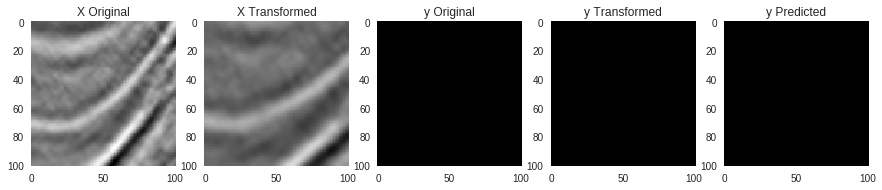

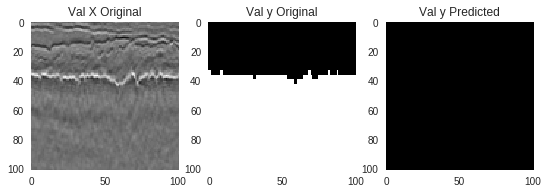

04/10/2018 13:39:56 - salt_model_v37_refactor_aug_test1 - INFO - Model state is not saved as the out_file_prefix is None
04/10/2018 13:39:56 - salt_model_v37_refactor_aug_test1 - INFO - Best Val Mean IOU so far: 0.125
04/10/2018 13:39:56 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 1
04/10/2018 13:39:56 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0099]
04/10/2018 13:39:56 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 2/50
04/10/2018 13:39:56 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:39:58 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5625, Acc: 0.8573, Loss: [0.7529, 0.0974, 0.8503] at epoch 2


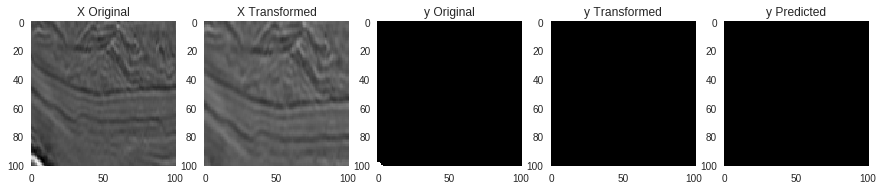

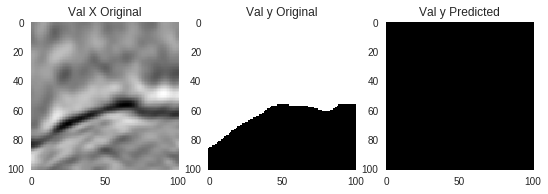

04/10/2018 13:39:59 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 2
04/10/2018 13:39:59 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0099]
04/10/2018 13:39:59 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 3/50
04/10/2018 13:39:59 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:01 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5625, Acc: 0.8534, Loss: [0.7071, 0.1006, 0.8077] at epoch 3


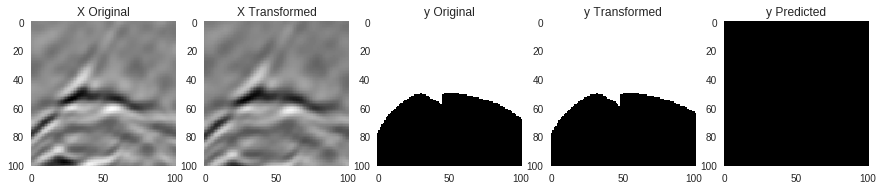

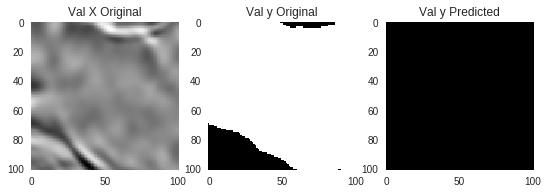

04/10/2018 13:40:02 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 3
04/10/2018 13:40:02 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0098]
04/10/2018 13:40:02 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 4/50
04/10/2018 13:40:02 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:04 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8610, Loss: [0.614, 0.1096, 0.7236] at epoch 4


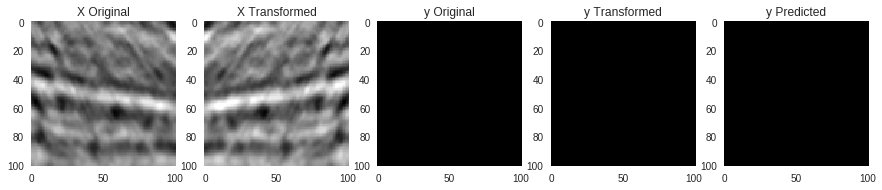

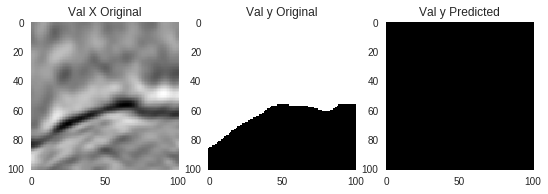

04/10/2018 13:40:05 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 4
04/10/2018 13:40:05 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0098]
04/10/2018 13:40:05 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 5/50
04/10/2018 13:40:05 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:07 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8508, Loss: [0.7464, 0.1221, 0.8684] at epoch 5


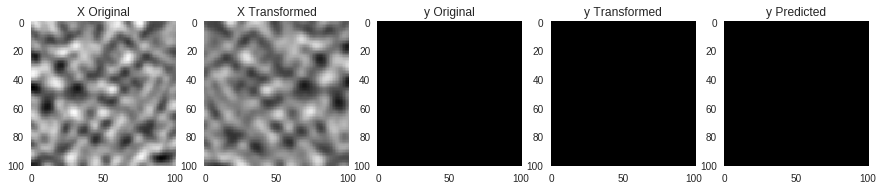

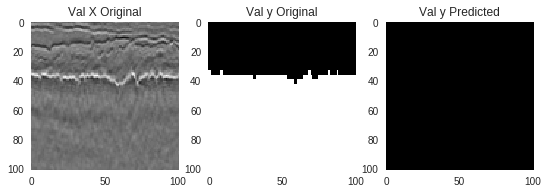

04/10/2018 13:40:08 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 5
04/10/2018 13:40:08 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0097]
04/10/2018 13:40:08 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 6/50
04/10/2018 13:40:08 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:10 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8358, Loss: [0.6983, 0.1012, 0.7995] at epoch 6


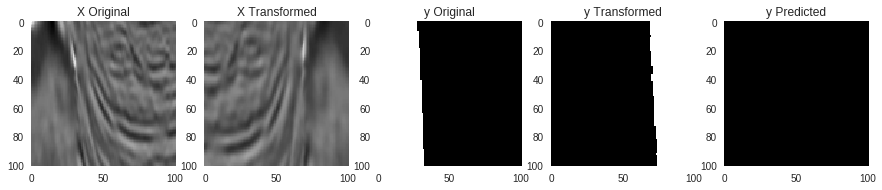

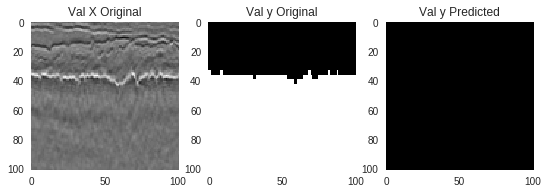

04/10/2018 13:40:11 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 6
04/10/2018 13:40:11 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0096]
04/10/2018 13:40:11 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 7/50
04/10/2018 13:40:11 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:12 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6250, Acc: 0.8555, Loss: [0.6637, 0.0839, 0.7475] at epoch 7


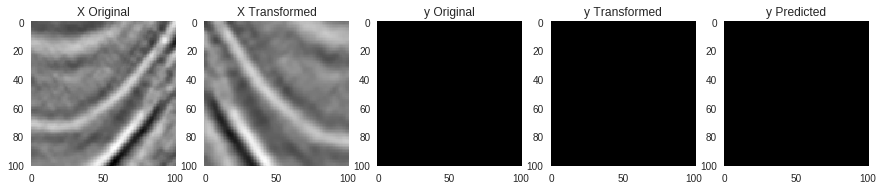

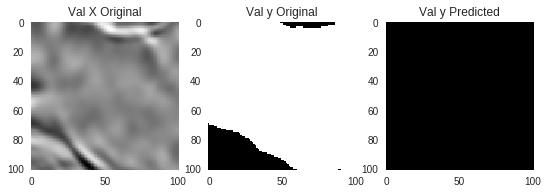

04/10/2018 13:40:14 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 7
04/10/2018 13:40:14 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0096]
04/10/2018 13:40:14 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 8/50
04/10/2018 13:40:14 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:15 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8599, Loss: [0.6361, 0.1012, 0.7373] at epoch 8


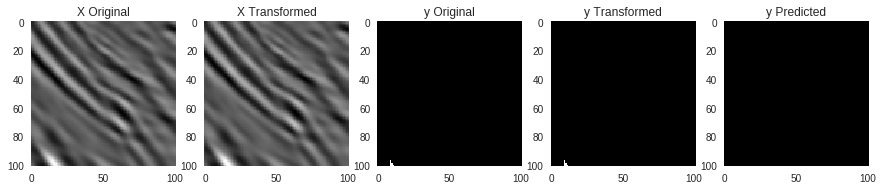

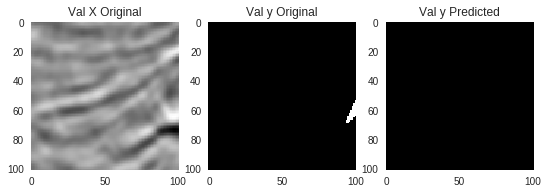

04/10/2018 13:40:16 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 8
04/10/2018 13:40:16 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.001, 0.0095]
04/10/2018 13:40:16 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 9/50
04/10/2018 13:40:16 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:18 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8595, Loss: [0.6216, 0.1047, 0.7263] at epoch 9


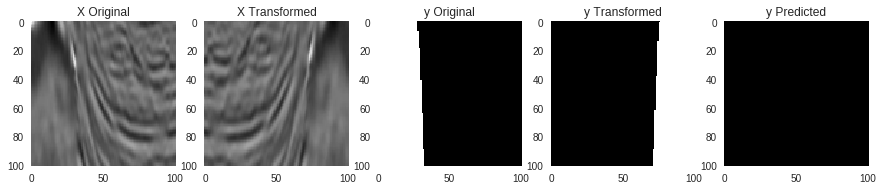

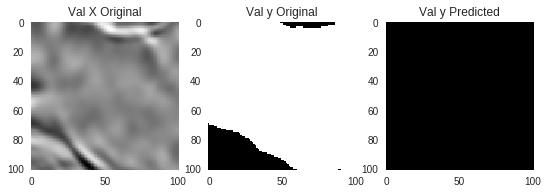

04/10/2018 13:40:19 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 9
04/10/2018 13:40:19 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0095]
04/10/2018 13:40:19 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 10/50
04/10/2018 13:40:19 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:21 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5625, Acc: 0.8490, Loss: [0.6072, 0.095, 0.7022] at epoch 10


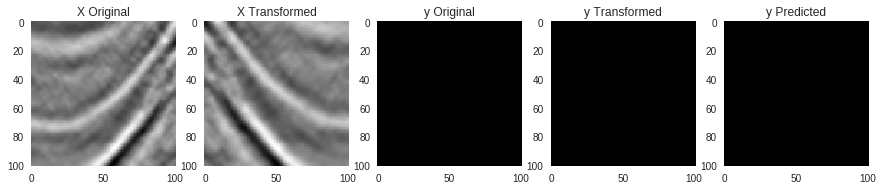

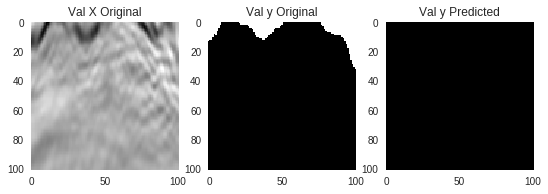

04/10/2018 13:40:22 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 10
04/10/2018 13:40:22 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0094]
04/10/2018 13:40:22 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 11/50
04/10/2018 13:40:22 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:23 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8497, Loss: [0.581, 0.1064, 0.6874] at epoch 11


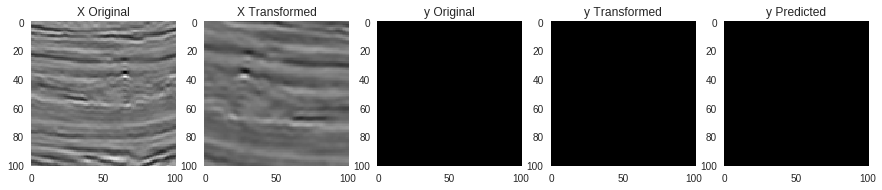

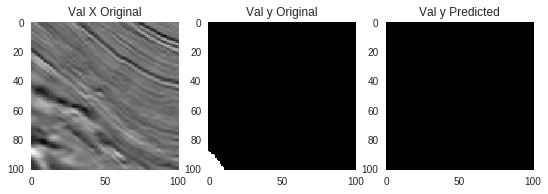

04/10/2018 13:40:25 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 11
04/10/2018 13:40:25 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0093]
04/10/2018 13:40:25 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 12/50
04/10/2018 13:40:25 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:26 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6250, Acc: 0.8496, Loss: [0.4886, 0.0732, 0.5619] at epoch 12


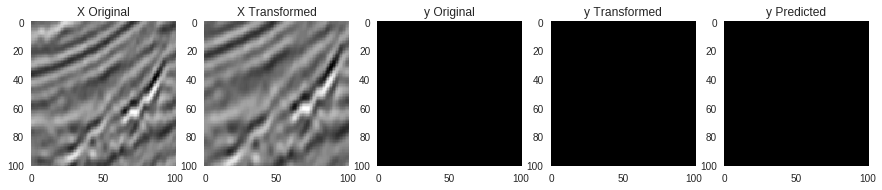

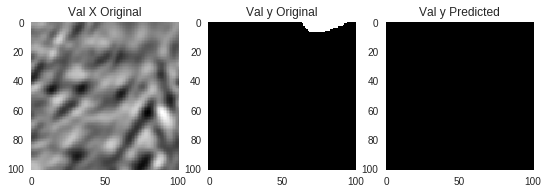

04/10/2018 13:40:27 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 12
04/10/2018 13:40:27 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0093]
04/10/2018 13:40:27 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 13/50
04/10/2018 13:40:27 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:29 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5625, Acc: 0.8588, Loss: [0.4785, 0.1115, 0.59] at epoch 13


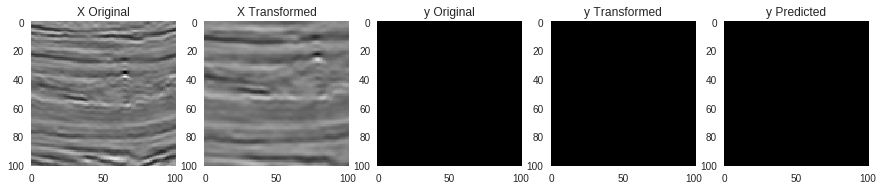

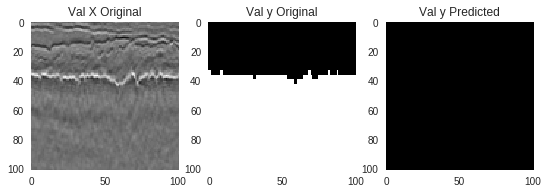

04/10/2018 13:40:30 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 13
04/10/2018 13:40:30 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0092]
04/10/2018 13:40:30 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 14/50
04/10/2018 13:40:30 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:31 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8517, Loss: [0.426, 0.0979, 0.5239] at epoch 14


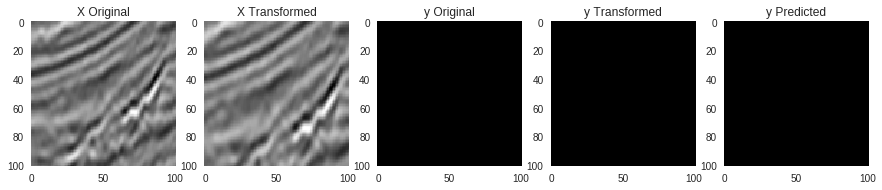

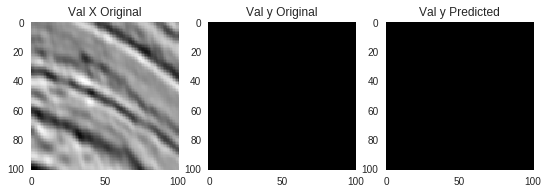

04/10/2018 13:40:32 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 14
04/10/2018 13:40:32 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0092]
04/10/2018 13:40:32 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 15/50
04/10/2018 13:40:32 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:34 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5625, Acc: 0.8666, Loss: [0.6994, 0.1137, 0.8131] at epoch 15


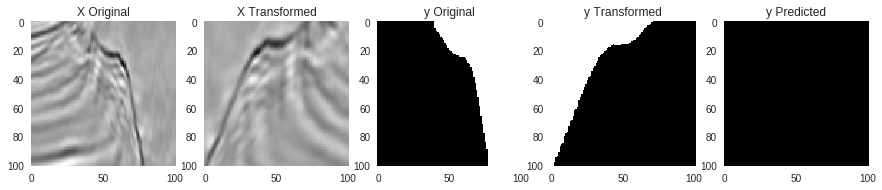

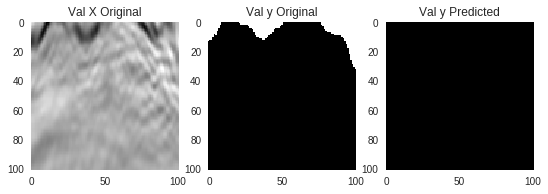

04/10/2018 13:40:35 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 15
04/10/2018 13:40:35 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0091]
04/10/2018 13:40:35 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 16/50
04/10/2018 13:40:35 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:37 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6250, Acc: 0.8523, Loss: [0.575, 0.0918, 0.6668] at epoch 16


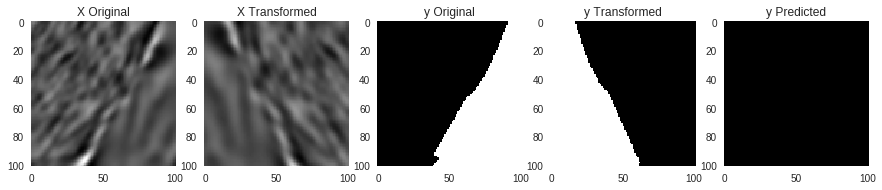

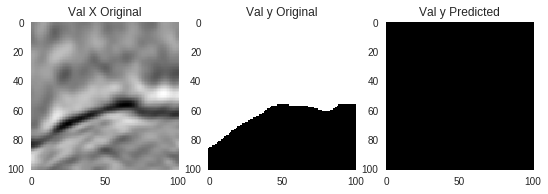

04/10/2018 13:40:38 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 16
04/10/2018 13:40:38 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.009]
04/10/2018 13:40:38 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 17/50
04/10/2018 13:40:38 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:39 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5625, Acc: 0.8620, Loss: [0.4294, 0.1159, 0.5453] at epoch 17


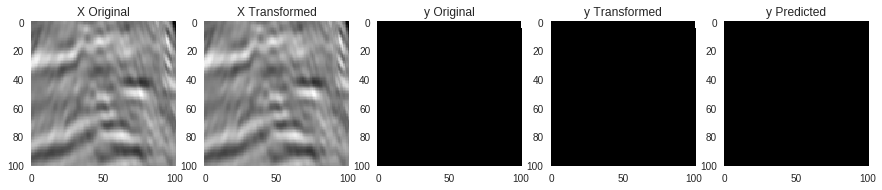

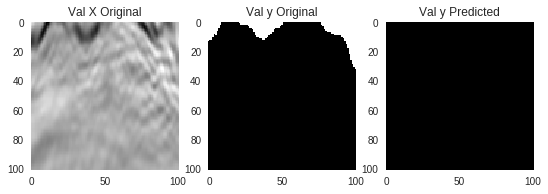

04/10/2018 13:40:40 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 17
04/10/2018 13:40:40 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.009]
04/10/2018 13:40:40 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 18/50
04/10/2018 13:40:40 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:42 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5625, Acc: 0.8534, Loss: [0.6775, 0.1091, 0.7866] at epoch 18


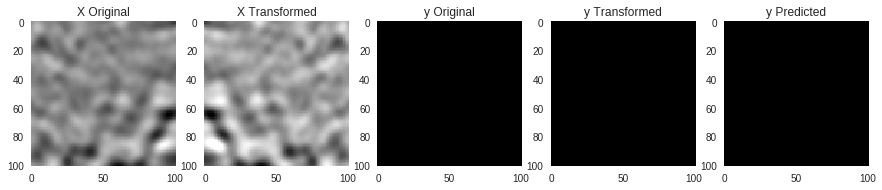

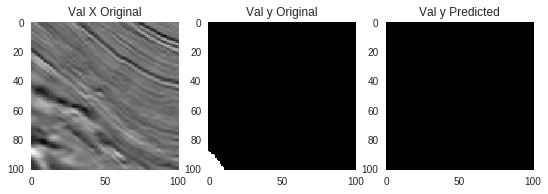

04/10/2018 13:40:43 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 18
04/10/2018 13:40:43 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0089]
04/10/2018 13:40:43 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 19/50
04/10/2018 13:40:43 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:45 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5625, Acc: 0.8605, Loss: [0.6372, 0.0944, 0.7316] at epoch 19


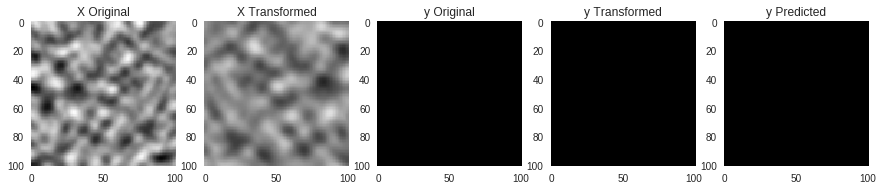

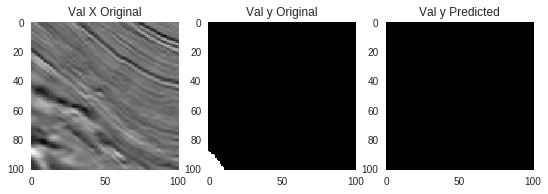

04/10/2018 13:40:46 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 19
04/10/2018 13:40:46 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0089]
04/10/2018 13:40:46 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 20/50
04/10/2018 13:40:46 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:47 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6250, Acc: 0.8648, Loss: [0.5418, 0.0829, 0.6247] at epoch 20


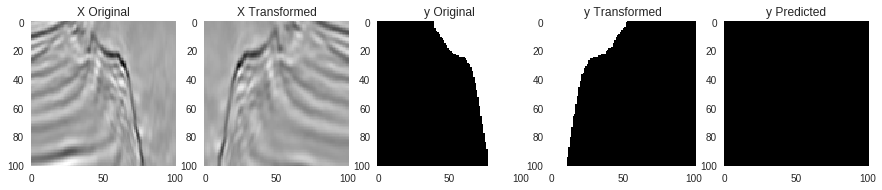

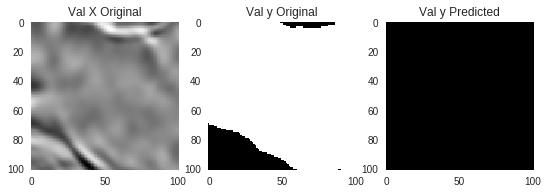

04/10/2018 13:40:48 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 20
04/10/2018 13:40:48 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0088]
04/10/2018 13:40:48 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 21/50
04/10/2018 13:40:48 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:50 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8589, Loss: [0.4418, 0.1063, 0.5481] at epoch 21


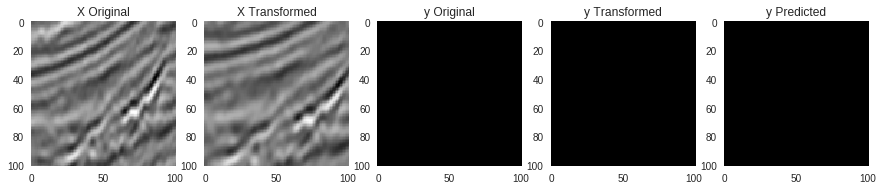

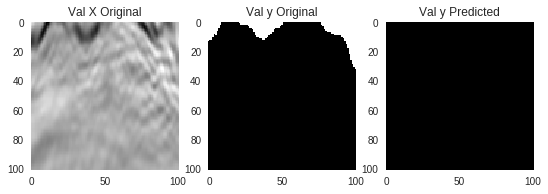

04/10/2018 13:40:51 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.1250 at epoch 21
04/10/2018 13:40:51 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0087]
04/10/2018 13:40:51 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 22/50
04/10/2018 13:40:51 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:52 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5625, Acc: 0.8491, Loss: [0.415, 0.0833, 0.4983] at epoch 22


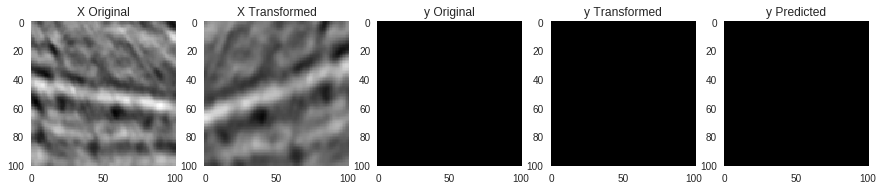

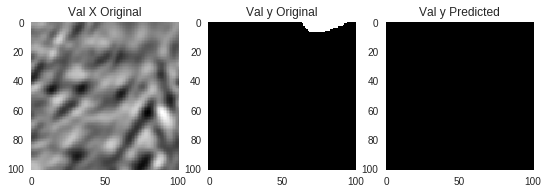

04/10/2018 13:40:54 - salt_model_v37_refactor_aug_test1 - INFO - Model state is not saved as the out_file_prefix is None
04/10/2018 13:40:54 - salt_model_v37_refactor_aug_test1 - INFO - Best Val Mean IOU so far: 0.30000000000000004
04/10/2018 13:40:54 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3000, Acc: 0.7645, Best Val IOU: 0.3000 at epoch 22
04/10/2018 13:40:54 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0087]
04/10/2018 13:40:54 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 23/50
04/10/2018 13:40:54 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:55 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.3438, Acc: 0.7801, Loss: [0.5988, 0.1074, 0.7062] at epoch 23


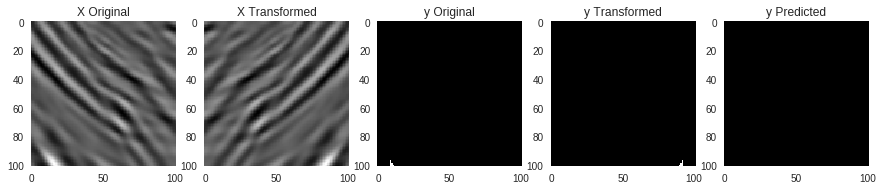

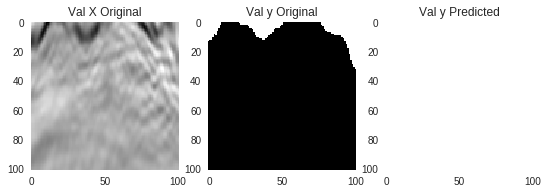

04/10/2018 13:40:56 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1500, Acc: 0.6940, Best Val IOU: 0.3000 at epoch 23
04/10/2018 13:40:56 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0086]
04/10/2018 13:40:56 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 24/50
04/10/2018 13:40:56 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:40:58 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.2000, Acc: 0.7090, Loss: [0.5537, 0.1042, 0.658] at epoch 24


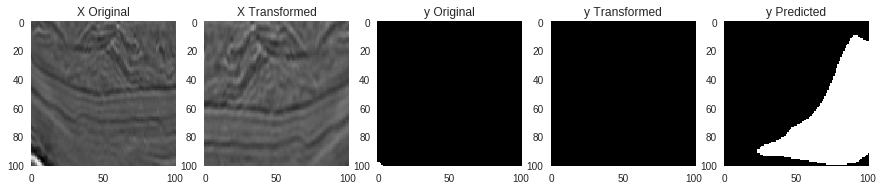

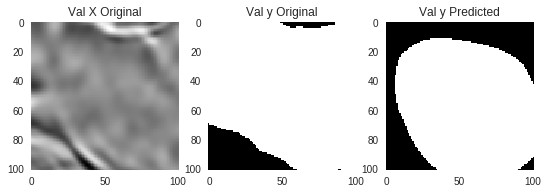

04/10/2018 13:40:59 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.2750, Acc: 0.7722, Best Val IOU: 0.3000 at epoch 24
04/10/2018 13:40:59 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0009, 0.0085]
04/10/2018 13:40:59 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 25/50
04/10/2018 13:40:59 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:00 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6250, Acc: 0.8519, Loss: [0.51, 0.0887, 0.5987] at epoch 25


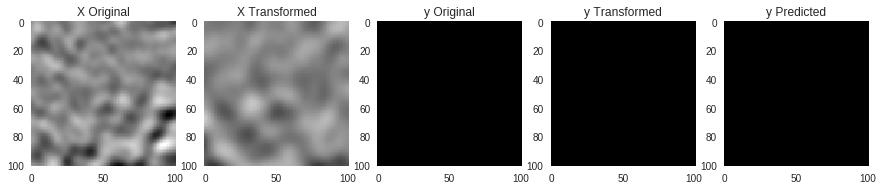

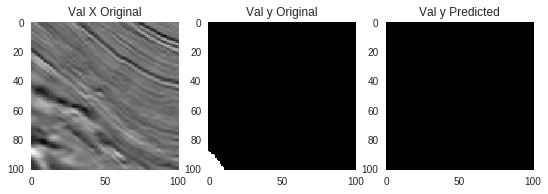

04/10/2018 13:41:01 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.3000 at epoch 25
04/10/2018 13:41:01 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0085]
04/10/2018 13:41:01 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 26/50
04/10/2018 13:41:01 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:03 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8513, Loss: [0.5642, 0.1128, 0.6771] at epoch 26


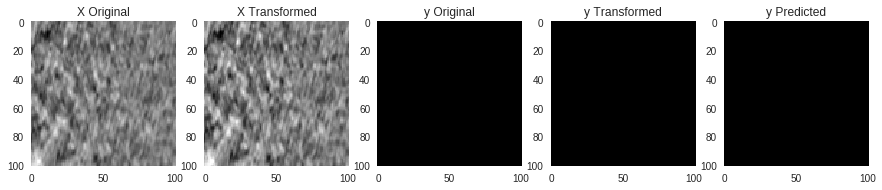

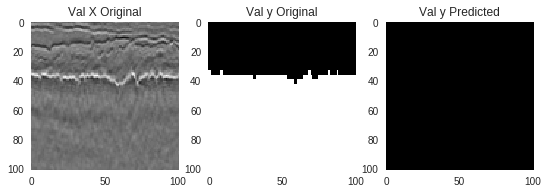

04/10/2018 13:41:04 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.3000 at epoch 26
04/10/2018 13:41:04 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0084]
04/10/2018 13:41:04 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 27/50
04/10/2018 13:41:04 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:05 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6250, Acc: 0.8482, Loss: [0.4294, 0.0811, 0.5105] at epoch 27


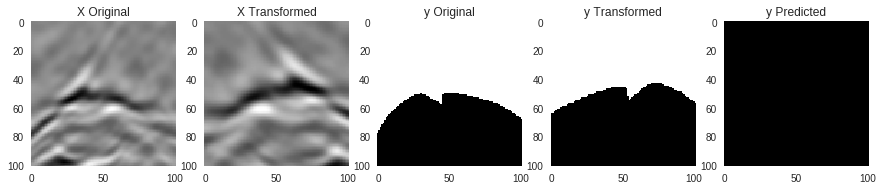

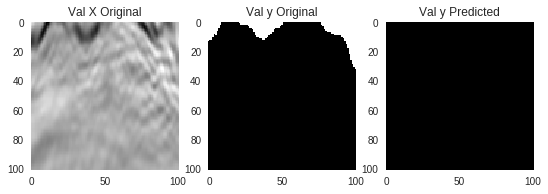

04/10/2018 13:41:07 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.3000 at epoch 27
04/10/2018 13:41:07 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0084]
04/10/2018 13:41:07 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 28/50
04/10/2018 13:41:07 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:08 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8467, Loss: [0.4067, 0.0933, 0.5] at epoch 28


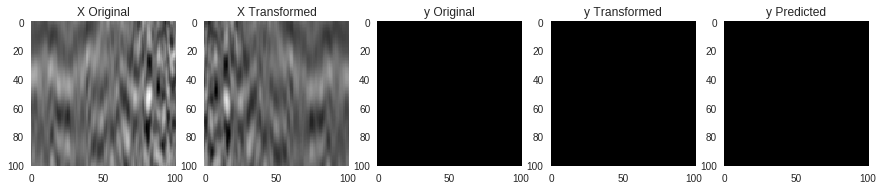

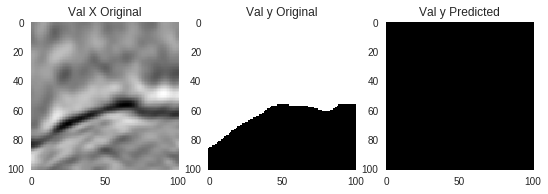

04/10/2018 13:41:09 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7205, Best Val IOU: 0.3000 at epoch 28
04/10/2018 13:41:09 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0083]
04/10/2018 13:41:09 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 29/50
04/10/2018 13:41:09 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:11 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5000, Acc: 0.8710, Loss: [0.3409, 0.1026, 0.4435] at epoch 29


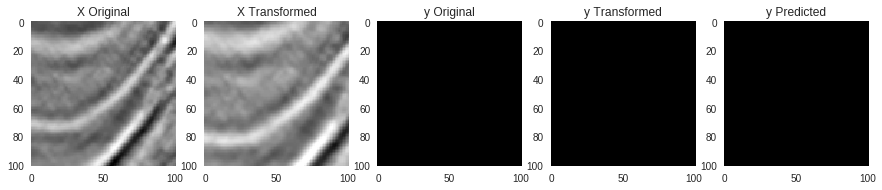

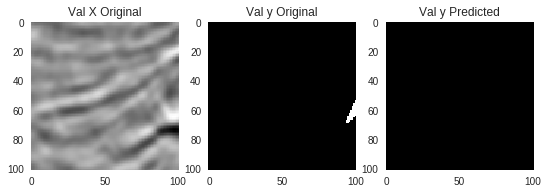

04/10/2018 13:41:12 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1250, Acc: 0.7078, Best Val IOU: 0.3000 at epoch 29
04/10/2018 13:41:12 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0082]
04/10/2018 13:41:12 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 30/50
04/10/2018 13:41:12 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:13 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.4500, Acc: 0.8988, Loss: [0.3438, 0.1029, 0.4467] at epoch 30


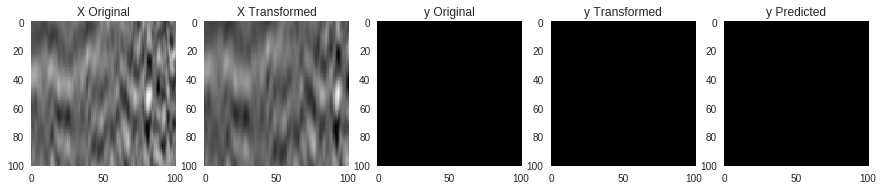

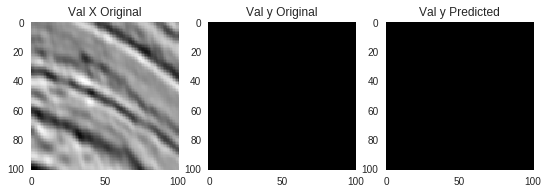

04/10/2018 13:41:15 - salt_model_v37_refactor_aug_test1 - INFO - Model state is not saved as the out_file_prefix is None
04/10/2018 13:41:15 - salt_model_v37_refactor_aug_test1 - INFO - Best Val Mean IOU so far: 0.3375
04/10/2018 13:41:15 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3375, Acc: 0.8242, Best Val IOU: 0.3375 at epoch 30
04/10/2018 13:41:15 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0082]
04/10/2018 13:41:15 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 31/50
04/10/2018 13:41:15 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:16 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.4625, Acc: 0.8563, Loss: [0.3947, 0.1229, 0.5176] at epoch 31


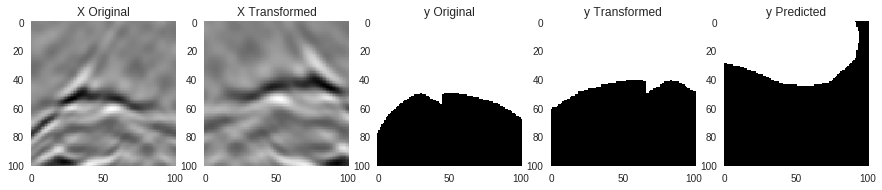

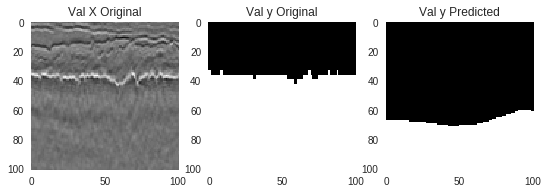

04/10/2018 13:41:17 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.2500, Acc: 0.8100, Best Val IOU: 0.3375 at epoch 31
04/10/2018 13:41:17 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0081]
04/10/2018 13:41:17 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 32/50
04/10/2018 13:41:17 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:19 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5188, Acc: 0.9171, Loss: [0.3116, 0.0874, 0.399] at epoch 32


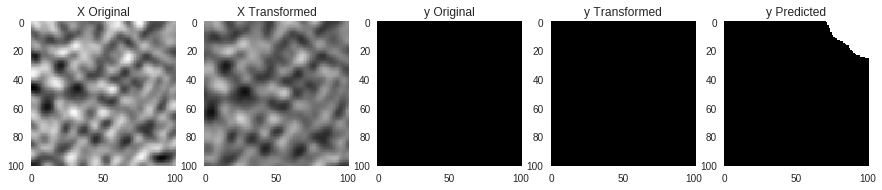

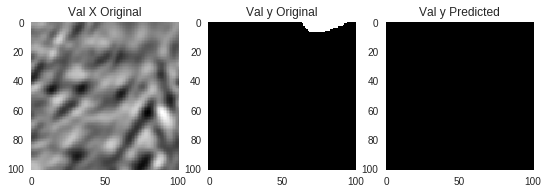

04/10/2018 13:41:20 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3250, Acc: 0.8099, Best Val IOU: 0.3375 at epoch 32
04/10/2018 13:41:20 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0081]
04/10/2018 13:41:20 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 33/50
04/10/2018 13:41:20 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:21 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.4000, Acc: 0.9003, Loss: [0.3022, 0.0955, 0.3977] at epoch 33


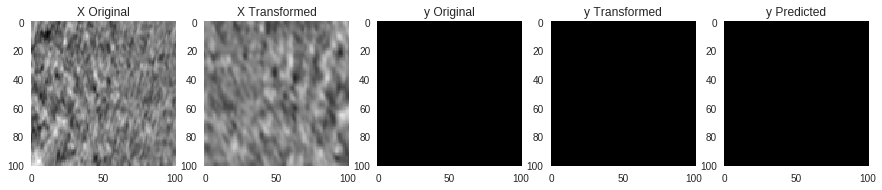

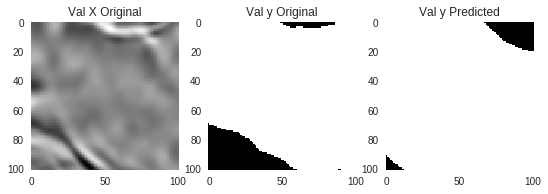

04/10/2018 13:41:23 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1625, Acc: 0.7607, Best Val IOU: 0.3375 at epoch 33
04/10/2018 13:41:23 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.008]
04/10/2018 13:41:23 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 34/50
04/10/2018 13:41:23 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:24 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.4313, Acc: 0.8609, Loss: [0.3345, 0.1024, 0.4369] at epoch 34


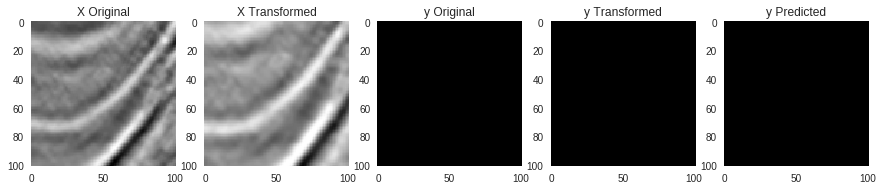

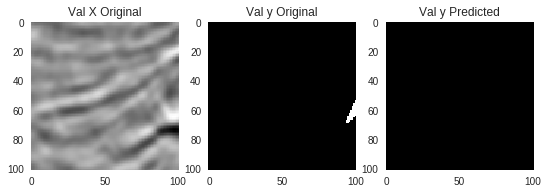

04/10/2018 13:41:25 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3125, Acc: 0.7761, Best Val IOU: 0.3375 at epoch 34
04/10/2018 13:41:25 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0079]
04/10/2018 13:41:25 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 35/50
04/10/2018 13:41:25 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:27 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.7312, Acc: 0.9752, Loss: [0.1748, 0.0499, 0.2247] at epoch 35


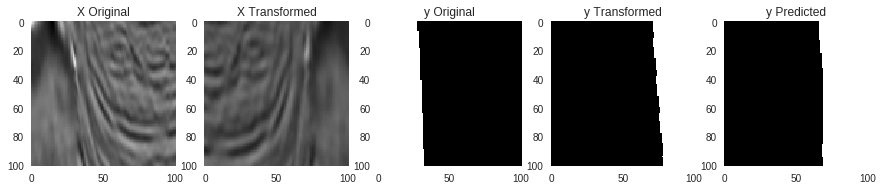

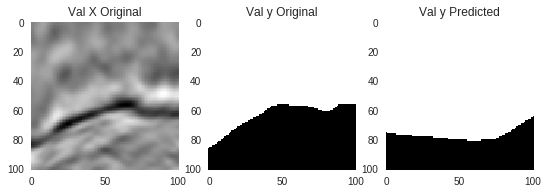

04/10/2018 13:41:28 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3125, Acc: 0.7983, Best Val IOU: 0.3375 at epoch 35
04/10/2018 13:41:28 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0079]
04/10/2018 13:41:28 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 36/50
04/10/2018 13:41:28 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:29 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6438, Acc: 0.9497, Loss: [0.174, 0.0681, 0.2421] at epoch 36


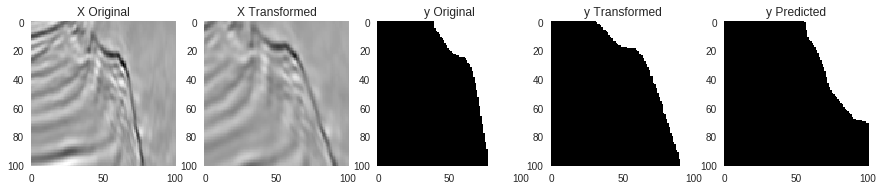

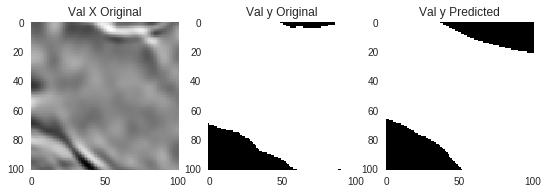

04/10/2018 13:41:30 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3250, Acc: 0.8083, Best Val IOU: 0.3375 at epoch 36
04/10/2018 13:41:30 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0078]
04/10/2018 13:41:30 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 37/50
04/10/2018 13:41:30 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:32 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.7000, Acc: 0.9662, Loss: [0.0987, 0.0669, 0.1656] at epoch 37


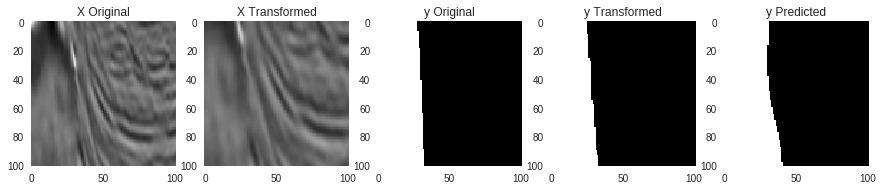

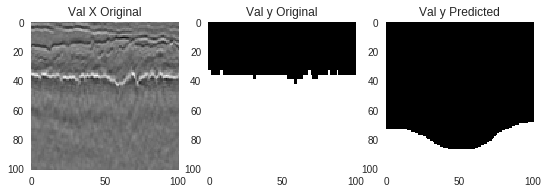

04/10/2018 13:41:33 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3125, Acc: 0.7970, Best Val IOU: 0.3375 at epoch 37
04/10/2018 13:41:33 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0077]
04/10/2018 13:41:33 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 38/50
04/10/2018 13:41:33 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:35 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6187, Acc: 0.9628, Loss: [0.1168, 0.0824, 0.1992] at epoch 38


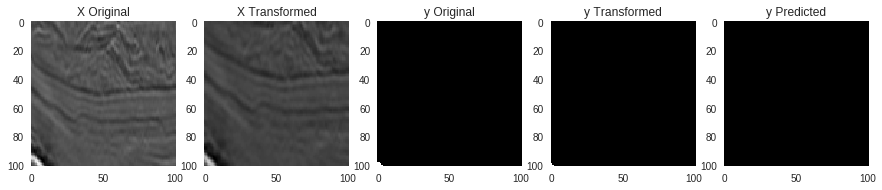

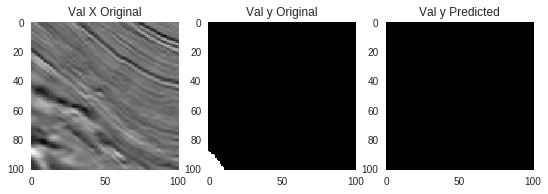

04/10/2018 13:41:36 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3000, Acc: 0.7753, Best Val IOU: 0.3375 at epoch 38
04/10/2018 13:41:36 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0077]
04/10/2018 13:41:36 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 39/50
04/10/2018 13:41:36 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:37 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5063, Acc: 0.8686, Loss: [0.905, 0.141, 1.0461] at epoch 39


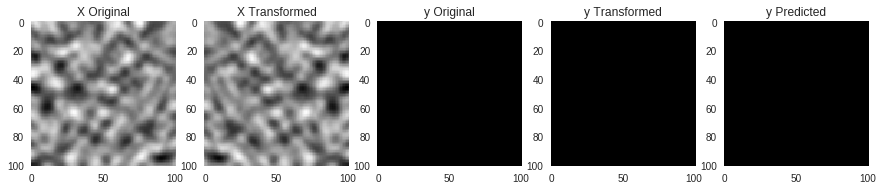

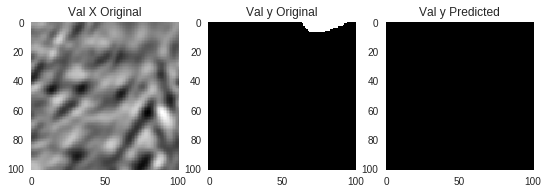

04/10/2018 13:41:38 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.2375, Acc: 0.8105, Best Val IOU: 0.3375 at epoch 39
04/10/2018 13:41:38 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0076]
04/10/2018 13:41:38 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 40/50
04/10/2018 13:41:38 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:40 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5938, Acc: 0.9254, Loss: [0.5045, 0.0898, 0.5943] at epoch 40


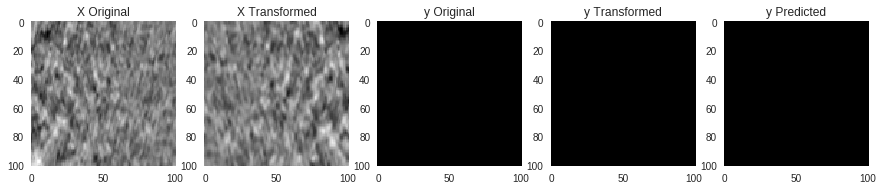

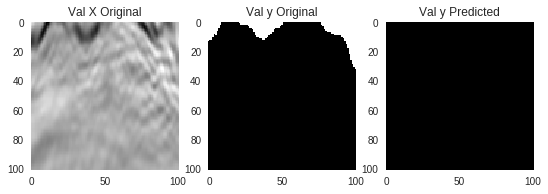

04/10/2018 13:41:41 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1875, Acc: 0.8057, Best Val IOU: 0.3375 at epoch 40
04/10/2018 13:41:41 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0076]
04/10/2018 13:41:41 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 41/50
04/10/2018 13:41:41 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:42 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5687, Acc: 0.9305, Loss: [0.4518, 0.0854, 0.5372] at epoch 41


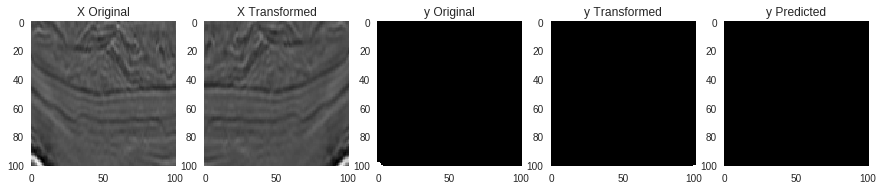

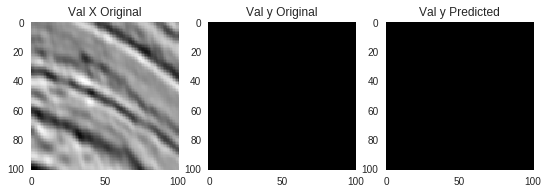

04/10/2018 13:41:44 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.1750, Acc: 0.8026, Best Val IOU: 0.3375 at epoch 41
04/10/2018 13:41:44 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0008, 0.0075]
04/10/2018 13:41:44 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 42/50
04/10/2018 13:41:44 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:45 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5062, Acc: 0.8579, Loss: [0.4417, 0.1175, 0.5592] at epoch 42


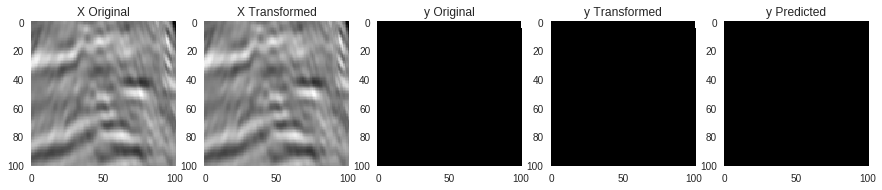

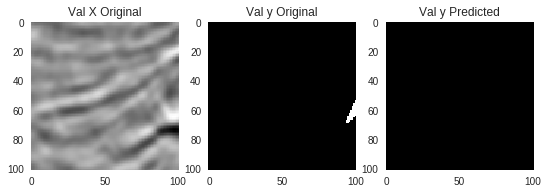

04/10/2018 13:41:46 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.2875, Acc: 0.8037, Best Val IOU: 0.3375 at epoch 42
04/10/2018 13:41:46 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0007, 0.0074]
04/10/2018 13:41:46 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 43/50
04/10/2018 13:41:46 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:48 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.7312, Acc: 0.9644, Loss: [0.1996, 0.066, 0.2656] at epoch 43


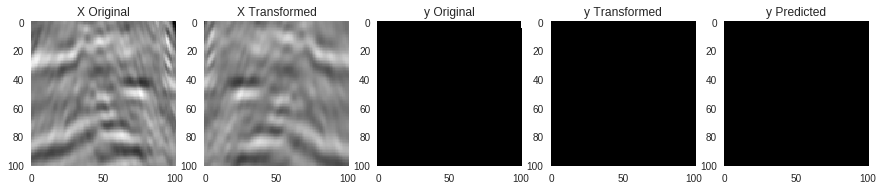

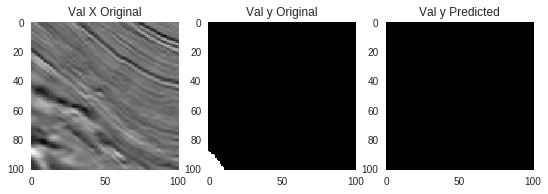

04/10/2018 13:41:49 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3375, Acc: 0.7905, Best Val IOU: 0.3375 at epoch 43
04/10/2018 13:41:49 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0007, 0.0074]
04/10/2018 13:41:49 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 44/50
04/10/2018 13:41:49 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:50 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.3875, Acc: 0.8748, Loss: [0.5476, 0.1195, 0.667] at epoch 44


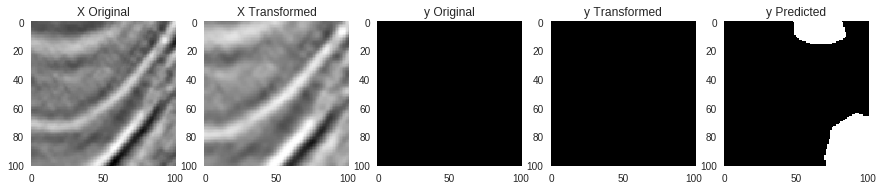

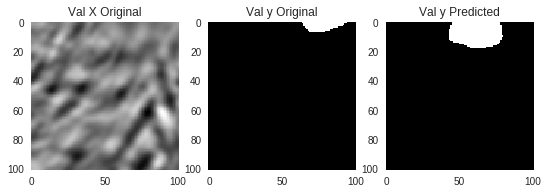

04/10/2018 13:41:52 - salt_model_v37_refactor_aug_test1 - INFO - Model state is not saved as the out_file_prefix is None
04/10/2018 13:41:52 - salt_model_v37_refactor_aug_test1 - INFO - Best Val Mean IOU so far: 0.375
04/10/2018 13:41:52 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3750, Acc: 0.8184, Best Val IOU: 0.3750 at epoch 44
04/10/2018 13:41:52 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0007, 0.0073]
04/10/2018 13:41:52 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 45/50
04/10/2018 13:41:52 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:53 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.5563, Acc: 0.9238, Loss: [0.2877, 0.0888, 0.3765] at epoch 45


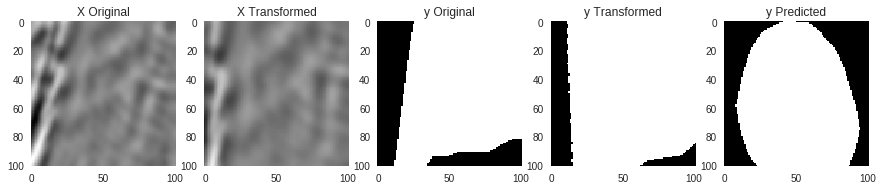

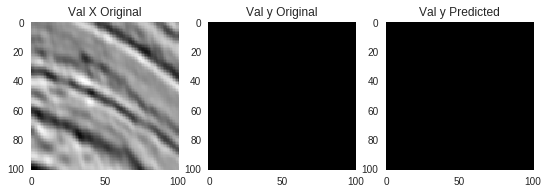

04/10/2018 13:41:54 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3375, Acc: 0.8720, Best Val IOU: 0.3750 at epoch 45
04/10/2018 13:41:54 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0007, 0.0073]
04/10/2018 13:41:54 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 46/50
04/10/2018 13:41:54 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:56 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.7500, Acc: 0.9738, Loss: [0.1839, 0.0469, 0.2308] at epoch 46


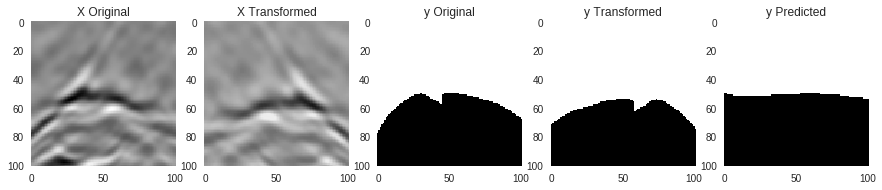

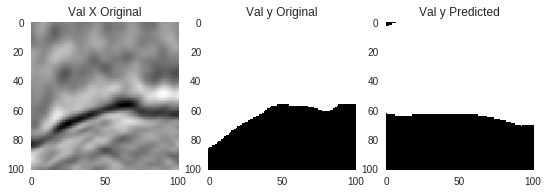

04/10/2018 13:41:57 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3375, Acc: 0.8892, Best Val IOU: 0.3750 at epoch 46
04/10/2018 13:41:57 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0007, 0.0072]
04/10/2018 13:41:57 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 47/50
04/10/2018 13:41:57 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:41:58 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.7125, Acc: 0.9442, Loss: [0.2251, 0.061, 0.286] at epoch 47


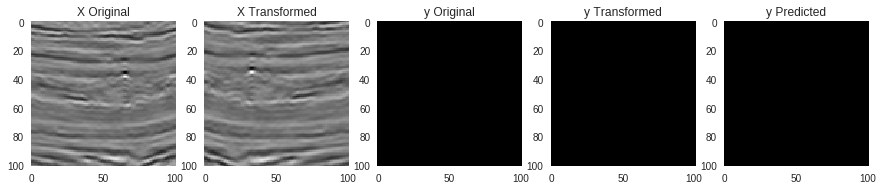

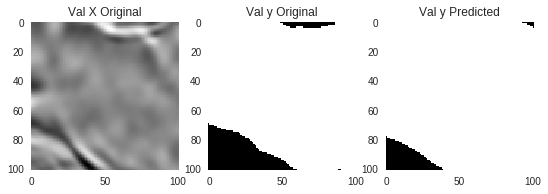

04/10/2018 13:42:00 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3750, Acc: 0.8934, Best Val IOU: 0.3750 at epoch 47
04/10/2018 13:42:00 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0007, 0.0071]
04/10/2018 13:42:00 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 48/50
04/10/2018 13:42:00 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:42:01 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.7438, Acc: 0.9612, Loss: [0.1388, 0.0506, 0.1894] at epoch 48


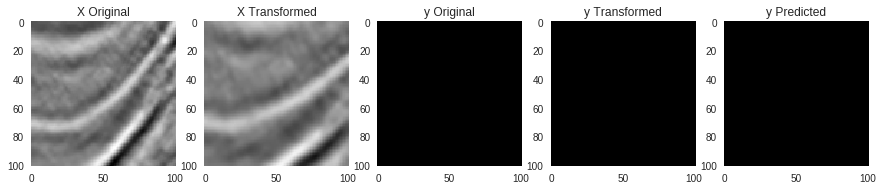

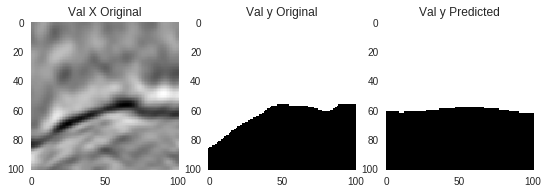

04/10/2018 13:42:02 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3625, Acc: 0.8935, Best Val IOU: 0.3750 at epoch 48
04/10/2018 13:42:02 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0007, 0.0071]
04/10/2018 13:42:02 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 49/50
04/10/2018 13:42:02 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:42:04 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6750, Acc: 0.9607, Loss: [0.158, 0.0725, 0.2305] at epoch 49


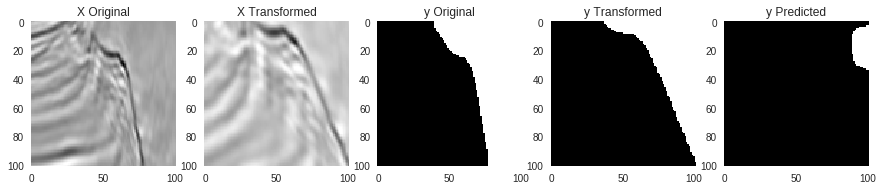

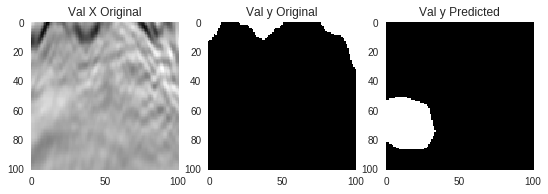

04/10/2018 13:42:05 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3125, Acc: 0.8661, Best Val IOU: 0.3750 at epoch 49
04/10/2018 13:42:05 - salt_model_v37_refactor_aug_test1 - INFO - Skip pushing model to git as model_save_name is None.
04/10/2018 13:42:05 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0007, 0.007]
04/10/2018 13:42:05 - salt_model_v37_refactor_aug_test1 - INFO - Epoch 50/50
04/10/2018 13:42:05 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:42:06 - salt_model_v37_refactor_aug_test1 - INFO - Train IOU: 0.6875, Acc: 0.9611, Loss: [0.138, 0.0696, 0.2077] at epoch 50


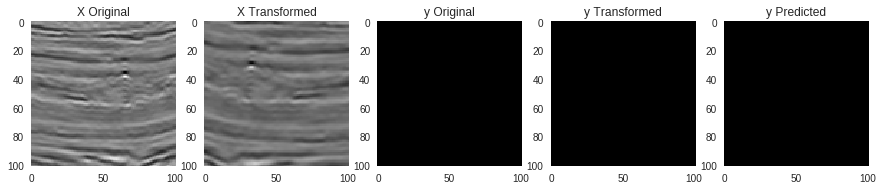

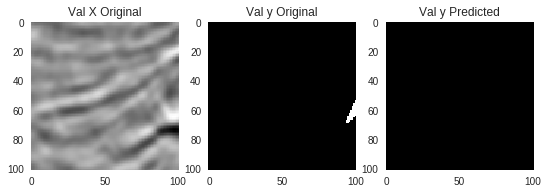

04/10/2018 13:42:07 - salt_model_v37_refactor_aug_test1 - INFO - Val   IOU: 0.3750, Acc: 0.8317, Best Val IOU: 0.3750 at epoch 50
04/10/2018 13:42:07 - salt_model_v37_refactor_aug_test1 - INFO - LR: [0.0007, 0.0069]
04/10/2018 13:42:08 - salt_model_v37_refactor_aug_test1 - INFO - --------------------
04/10/2018 13:42:08 - salt_model_v37_refactor_aug_test1 - INFO - Training complete in 2.0 mins. Best Val IOU 0.375


In [27]:
setup_train(config_list)

## Train the full with full dataset

In [28]:
log.info('Rerun the IOU 0.82 Unet34 baseline with grouped optimizer and refactored data aug')

04/10/2018 13:42:28 - salt_model_v37_refactor_aug_test1 - INFO - Rerun the IOU 0.82 Unet34 baseline with grouped optimizer and refactored data aug


In [0]:
aug_pipeline_config = '''
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.random_brightness(probability=0.5,0.8,1.2)
p.random_contrast(probability=0.5,0.8,1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.8, max_factor=1.0, mask_diff_pct=0.2)
'''

In [0]:
data_loader_config = '''
train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1,
                           transform=p.torch_transform()), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}
'''

In [0]:
model_config = '''
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
resnet_params = (
    list(saltnet.conv1.parameters()) + 
    list(saltnet.encoder2.parameters()) + 
    list(saltnet.encoder3.parameters()) + 
    list(saltnet.encoder4.parameters()) + 
    list(saltnet.encoder5.parameters())
)

unet_params = (
    list(saltnet.center.parameters()) + 
    list(saltnet.decoder5.parameters()) + 
    list(saltnet.decoder4.parameters()) + 
    list(saltnet.decoder3.parameters()) + 
    list(saltnet.decoder2.parameters()) + 
    list(saltnet.decoder1.parameters())  + 
    list(saltnet.se_f.parameters()) + 
    list(saltnet.outc.parameters())
)

optimizer = optim.SGD([    
    {'params': resnet_params, 'lr': 1e-4},
    {'params': unet_params, 'lr': 1e-3},
], momentum=0.9, weight_decay=0.00001)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, min_lr=0.00001)
scheduler = PolyLR(optimizer, [1e-4, 1e-3], lr_decay_iter=1, max_iter=150, power=0.9)
model_save_name = f'../salt_net/salt_model_v37_refactor_aug_test1_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)
'''

In [0]:
train_params_config = '''
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 150,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.82
    }
'''

In [0]:
model_run_config = '''
train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.1), optimizer, scheduler, train_params, all_data)
'''

In [0]:
config_list = [aug_pipeline_config, data_loader_config, model_config, train_params_config, model_run_config]

In [35]:
setup_train(config_list)

04/10/2018 13:43:52 - salt_model_v37_refactor_aug_test1 - INFO - 
p = Pipeline_Salt()
p.flip_left_right(probability=0.5)
p.random_brightness(probability=0.5,0.8,1.2)
p.random_contrast(probability=0.5,0.8,1.2)
p.rotate_random_align(probability=0.5)
p.crop_random_align(probability=0.5, min_factor=0.8, max_factor=1.0, mask_diff_pct=0.2)

04/10/2018 13:43:52 - salt_model_v37_refactor_aug_test1 - INFO - 
train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_v

SyntaxError: ignored